In [1]:
%pip install opencv-python numpy matplotlib scipy mediapipe torch torchvision --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# Configuration OpenPose (COCO 18 points)
protoFile = "./openpose/models/pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "./openpose/models/pose/coco/pose_iter_440000.caffemodel"


In [ ]:
def detect_pose_openpose(image_path):
    """
    Détectons les points 2D du corps avec OpenPose.
    """
    # Chargeons l’image
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Erreur : {image_path} introuvable")
        return None, None
    
    # Chargeons le modèle OpenPose
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    frameHeight, frameWidth = frame.shape[:2]
    
    # Préparons le blob d’entrée
    inpBlob = cv2.dnn.blobFromImage(
        frame, 1.0/255, (368, 368), (0, 0, 0), swapRB=False, crop=False
    )
    net.setInput(inpBlob)
    output = net.forward()
    
    points = []
    threshold = 0.1
    H, W = output.shape[2], output.shape[3]
    
    # Extrayons les points clés avec un seuil de confiance
    for i in range(18):
        probMap = output[0, i, :, :]
        _, prob, _, point = cv2.minMaxLoc(probMap)
        
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        
        if prob > threshold and i not in [14, 15, 16, 17]:
            points.append((int(x), int(y)))
        else:
            points.append(None)
    
    return frame, points


def detect_a4_calibration(frames):
    """
    Détectons une feuille A4 pour calibrer l’échelle (29.7 cm).
    """
    a4_heights = []
    a4_real_cm = 29.7
    
    for i, frame in enumerate(frames):
        # Convertissons l’image en niveaux de gris
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Segmentons les zones blanches
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        
        # Parcourons les plus grands contours
        for cnt in sorted(contours, key=cv2.contourArea, reverse=True):
            if cv2.contourArea(cnt) > 30000:
                rect = cv2.minAreaRect(cnt)
                w, h = rect[1]
                if w == 0 or h == 0:
                    continue
                
                # Vérifions le ratio caractéristique d’une A4
                ratio = max(w, h) / min(w, h)
                if 1.3 < ratio < 1.5:
                    box = cv2.boxPoints(rect)
                    height_px = max(
                        np.linalg.norm(box[0] - box[2]),
                        np.linalg.norm(box[1] - box[3])
                    )
                    a4_heights.append(height_px)
                    print(f"A4 détecté sur vue {i+1} : {height_px:.0f} px")
                    break
    
    # Calculons le facteur d’échelle moyen
    if a4_heights:
        height_px = np.mean(a4_heights)
        scale = a4_real_cm / height_px
        return scale, True
    
    return None, False


def simple_3d_triangulation(points_front, points_side):
    """
    Reconstruisons une 3D simple à partir de la vue face et profil.
    """
    points_3d = []
    
    # Fusionnons les points face / profil
    for pf, ps in zip(points_front, points_side):
        if pf is None or ps is None:
            points_3d.append(None)
        else:
            x = (pf[0] + ps[0]) / 2.0
            y = (pf[1] + ps[1]) / 2.0
            z = abs(pf[0] - ps[0]) * 0.3  # profondeur empirique
            points_3d.append(np.array([x, y, z], dtype=float))
    
    return points_3d


In [ ]:
def calculate_tailor_body_metrics(points_3d, scale_factor):
    """
    Calculons les mesures tailleur en centimètres à partir des points 3D.
    """

    def get_point(i):
        # Récupérons un point s’il existe
        if i >= len(points_3d) or points_3d[i] is None:
            return None
        return points_3d[i]

    res = {}

    # Récupérons les points clés COCO / OpenPose
    p_nose      = get_point(0)
    p_neck      = get_point(1)
    p_rshoulder = get_point(2)
    p_relbow    = get_point(3)
    p_rwrist    = get_point(4)
    p_lshoulder = get_point(5)
    p_lelbow    = get_point(6)
    p_lwrist    = get_point(7)
    p_rhip      = get_point(8)
    p_rknee     = get_point(9)
    p_rankle    = get_point(10)
    p_lhip      = get_point(11)
    p_lknee     = get_point(12)
    p_lankle    = get_point(13)

    def ellipse_circumference(a, b):
        # Approximons le périmètre d’une ellipse (formule de Ramanujan)
        return math.pi * (3*(a+b) - math.sqrt((3*a + b) * (a + 3*b)))

    # Calculons la largeur d’épaules
    if p_rshoulder is not None and p_lshoulder is not None:
        res["Largeur épaules"] = np.linalg.norm(p_rshoulder - p_lshoulder) * scale_factor

    # Estimons le tour de poitrine via une ellipse largeur × profondeur
    if p_rshoulder is not None and p_lshoulder is not None:
        a = (np.linalg.norm(p_rshoulder - p_lshoulder) * scale_factor) / 2.0
        if p_rhip is not None and p_lhip is not None:
            depth_z = (abs(p_rshoulder[2] - p_rhip[2]) + abs(p_lshoulder[2] - p_lhip[2])) / 2.0
        else:
            depth_z = 0.3 * a
        b = max(depth_z * scale_factor, 0.3 * a)
        res["Tour de poitrine"] = ellipse_circumference(a, b)

    # Estimons le tour de hanches via une ellipse
    if p_rhip is not None and p_lhip is not None:
        a_h = (np.linalg.norm(p_rhip - p_lhip) * scale_factor) / 2.0
        if p_rknee is not None and p_lknee is not None:
            depth_z_h = (abs(p_rhip[2] - p_rknee[2]) + abs(p_lhip[2] - p_lknee[2])) / 2.0
        else:
            depth_z_h = 0.35 * a_h
        b_h = max(depth_z_h * scale_factor, 0.35 * a_h)
        res["Tour de hanches"] = ellipse_circumference(a_h, b_h)

    # Calculons la longueur de manche courte (épaule → coude)
    manches_courtes = []
    if p_rshoulder is not None and p_relbow is not None:
        manches_courtes.append(np.linalg.norm(p_rshoulder - p_relbow) * scale_factor)
    if p_lshoulder is not None and p_lelbow is not None:
        manches_courtes.append(np.linalg.norm(p_lshoulder - p_lelbow) * scale_factor)
    if manches_courtes:
        res["Longueur manche courte"] = max(manches_courtes)

    # Calculons la longueur de manche longue (épaule → poignet)
    manches_longues = []
    if p_rshoulder is not None and p_rwrist is not None:
        manches_longues.append(np.linalg.norm(p_rshoulder - p_rwrist) * scale_factor)
    if p_lshoulder is not None and p_lwrist is not None:
        manches_longues.append(np.linalg.norm(p_lshoulder - p_lwrist) * scale_factor)
    if manches_longues:
        res["Longueur manche longue"] = max(manches_longues)

    # Calculons la longueur du buste (cou → hanche)
    if p_neck is not None and (p_rhip is not None or p_lhip is not None):
        p_hip = p_rhip if p_rhip is not None else p_lhip
        res["Longueur buste"] = np.linalg.norm(p_neck - p_hip) * scale_factor

    # Calculons la longueur de culotte (hanche → genou)
    culotte = []
    if p_rhip is not None and p_rknee is not None:
        culotte.append(np.linalg.norm(p_rhip - p_rknee) * scale_factor)
    if p_lhip is not None and p_lknee is not None:
        culotte.append(np.linalg.norm(p_lhip - p_lknee) * scale_factor)
    if culotte:
        res["Longueur culotte"] = max(culotte)

    # Calculons la longueur du pantalon (hanche → cheville)
    pantalon = []
    if p_rhip is not None and p_rankle is not None:
        pantalon.append(np.linalg.norm(p_rhip - p_rankle) * scale_factor)
    if p_lhip is not None and p_lankle is not None:
        pantalon.append(np.linalg.norm(p_lhip - p_lankle) * scale_factor)
    if pantalon:
        res["Longueur pantalon"] = max(pantalon)

    # Estimons la hauteur totale (cou → cheville)
    chevilles = []
    if p_neck is not None and p_rankle is not None:
        chevilles.append(np.linalg.norm(p_neck - p_rankle) * scale_factor)
    if p_neck is not None and p_lankle is not None:
        chevilles.append(np.linalg.norm(p_neck - p_lankle) * scale_factor)
    if chevilles:
        res["Hauteur totale"] = max(chevilles)

    # Comptons les points 3D valides
    res["Points 3D détectés"] = str(sum(1 for p in points_3d if p is not None))

    return res


def estimate_tshirt_size(chest_circ_cm):
    """
    Estimons la taille de t-shirt à partir du tour de poitrine.
    """
    if chest_circ_cm is None:
        return "Inconnue"

    c = chest_circ_cm
    if c < 94:
        return "S"
    elif c < 102:
        return "M"
    elif c < 110:
        return "L"
    elif c < 118:
        return "XL"
    else:
        return "XXL"


In [7]:
def main_3d():
    # Chargeons les images (face et profil) et détectons les points du squelette
    print("Chargement des images...")
    frame_front, points_front = detect_pose_openpose("./HumanPoses/cr7.jpg")
    frame_side, points_side  = detect_pose_openpose("./HumanPoses/cr7profil.jpeg")
    
    # Vérifions que les images sont bien chargées
    if frame_front is None or frame_side is None:
        print("Erreur : images manquantes ou illisibles.")
        return
    
    frames = [frame_front, frame_side]
    
    # Essayons une calibration automatique avec une feuille A4
    scale_factor, a4_detected = detect_a4_calibration(frames)
    method = "A4"
    
    # Calculons une première reconstruction 3D (en pixels)
    points_3d = simple_3d_triangulation(points_front, points_side)
    
    # Si l’A4 n’est pas détectée, utilisons une autre méthode
    if not a4_detected:
        # Utilisons la taille (cou → cheville) pour calibrer
        p_neck  = points_3d[1] if len(points_3d) > 1 else None
        p_ankle = points_3d[10] if len(points_3d) > 10 else points_3d[13]
        
        if p_neck is not None and p_ankle is not None:
            hauteur_px = np.linalg.norm(p_neck - p_ankle)
            print(f"Hauteur détectée : {hauteur_px:.1f} px")
            
            taille_cm = float(input("Entrez votre taille (cm) : "))
            scale_factor = taille_cm / hauteur_px
            method = "Taille utilisateur"
        else:
            # Utilisons la largeur d’épaules comme dernier recours
            p_rshoulder = points_3d[2] if len(points_3d) > 2 else None
            p_lshoulder = points_3d[5] if len(points_3d) > 5 else None
            
            if p_rshoulder is None or p_lshoulder is None:
                print("Calibration impossible : épaules non détectées.")
                return
            
            largeur_px = np.linalg.norm(p_rshoulder - p_lshoulder)
            print(f"Largeur d’épaules détectée : {largeur_px:.1f} px")
            
            largeur_cm = float(input("Entrez votre largeur d’épaules (cm) : "))
            scale_factor = largeur_cm / largeur_px
            method = "Largeur d’épaules"
    
    # Affichons la méthode de calibration utilisée
    print(f"Calibration utilisée : {method} → {scale_factor:.4f} cm/pixel")
    
    # Recalculons les points 3D avec l’échelle finale
    points_3d = simple_3d_triangulation(points_front, points_side)
    
    # Calculons les mesures corporelles
    metrics = calculate_tailor_body_metrics(points_3d, scale_factor)
    metrics["Taille t-shirt"] = estimate_tshirt_size(metrics.get("Tour de poitrine"))
    
    # Affichons les mesures dans un ordre lisible
    print("\nMESURES TAILLEUR\n")
    ordre = [
        "Hauteur totale",
        "Largeur épaules",
        "Tour de poitrine",
        "Tour de hanches",
        "Longueur buste",
        "Longueur manche courte",
        "Longueur manche longue",
        "Longueur culotte",
        "Longueur pantalon",
        "Taille t-shirt",
        "Points 3D détectés",
    ]
    
    for key in ordre:
        if key not in metrics:
            continue
        val = metrics[key]
        if isinstance(val, (int, float)) and "Points" not in key and "Taille t-shirt" not in key:
            print(f"{key:22}: {val:6.1f} cm")
        else:
            print(f"{key:22}: {val}")
    
    # Affichons la vue frontale à l’échelle réelle
    h_f, w_f = frame_front.shape[:2]
    plt.figure(figsize=(w_f / 100, h_f / 100))
    plt.imshow(cv2.cvtColor(frame_front, cv2.COLOR_BGR2RGB))
    plt.title("Vue frontale")
    plt.axis("off")
    plt.show()
    
    # Affichons la vue profil à l’échelle réelle
    h_s, w_s = frame_side.shape[:2]
    plt.figure(figsize=(w_s / 100, h_s / 100))
    plt.imshow(cv2.cvtColor(frame_side, cv2.COLOR_BGR2RGB))
    plt.title("Vue profil")
    plt.axis("off")
    plt.show()
    
    # Affichons le squelette 3D séparément
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    
    valid_pts = [p for p in points_3d if p is not None]
    if valid_pts:
        pts = np.array(valid_pts)
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c="red", s=60)
    
    ax.set_title("Squelette 3D")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()


Chargement des images...
Hauteur détectée : 557.9 px
Calibration utilisée : Taille utilisateur → 0.3352 cm/pixel

MESURES TAILLEUR

Hauteur totale        :  188.0 cm
Largeur épaules       :   49.2 cm
Tour de poitrine      :  107.9 cm
Tour de hanches       :   67.5 cm
Longueur buste        :   67.9 cm
Longueur manche courte:   38.8 cm
Longueur manche longue:   54.3 cm
Longueur culotte      :   59.3 cm
Longueur pantalon     :  120.4 cm
Taille t-shirt        : L
Points 3D détectés    : 14


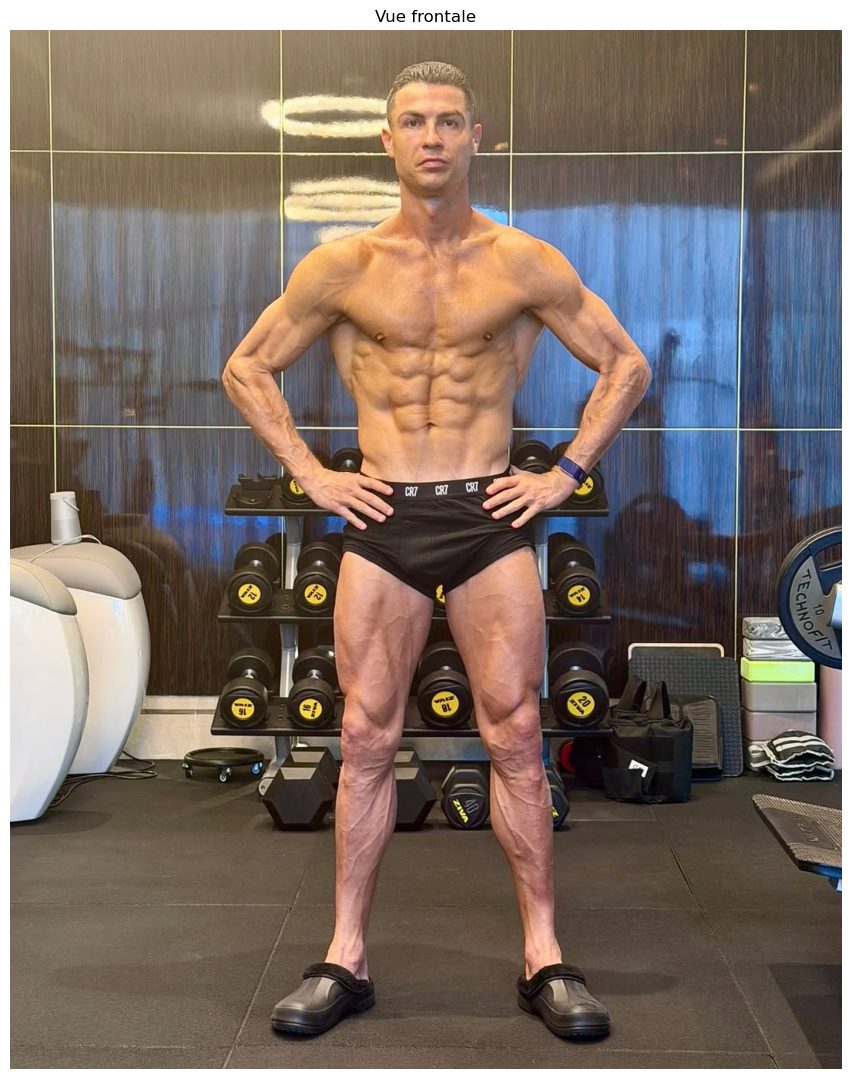

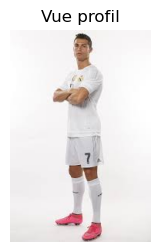

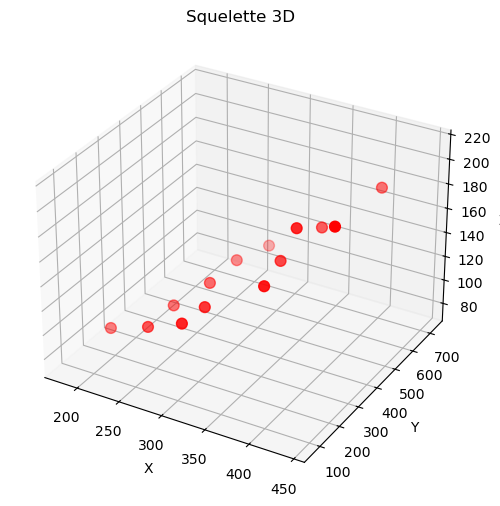

In [8]:
main_3d()
